<a href="https://colab.research.google.com/github/Christian-Braga/Binary-Signal-Recovery-Probability-Metropolis-Hasting-Algo/blob/master/test_repo_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'



In [ ]:
!git clone https://github.com/Christian-Braga/computational_social_science

Cloning into 'computational_social_science'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 59 (delta 15), reused 48 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 4.36 MiB | 8.64 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
!pip install unidecode
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.4 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
import transformers
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data

#preprocessing
import nltk
nltk.download('stopwords')
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from unidecode import unidecode
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset = pd.read_csv('df_merged.csv')
dataset

,text,likes,replies,date,sentiment
0,South Africa will continue to stand for the pe...,1,0,2024-10-07T13:31:33Z,1.0
1,Genocide started when the Palestinians let Ham...,2,1,2024-10-21T03:14:53Z,0.0
2,Thank you\n\nCommenting in hope that this vedi...,4,0,2024-03-24T15:55:44Z,2.0
3,So sorry,0,0,2024-07-30T17:48:24Z,2.0
4,Why ALLAH created man that Will shed blood,0,0,2024-10-04T10:45:42Z,2.0
...,...,...,...,...,...
18888,Israeli cowards,0,0,2023-12-02T09:23:30Z,NaN
18889,Thank you for this. Free Palestine 🇵🇸,0,0,2024-03-20T15:40:14Z,1.0
18890,I dont particularly like hamas infact i hate h...,0,0,2024-08-25T20:11:43Z,NaN
18891,The story of little Hind Rajab is missing? Wha...,0,0,2024-10-04T17:22:00Z,NaN


In [ ]:
df = dataset[dataset.sentiment.notna()] #to have only obs with target

In [ ]:
df.sentiment.value_counts()

,count
sentiment,
2.0,626
1.0,514
0.0,346


In [ ]:
df_fine_tune = df.drop(['likes', 'replies', 'date'],axis=1)
df_fine_tune #dataset for bert fine tuning

,text,sentiment
0,South Africa will continue to stand for the pe...,1.0
1,Genocide started when the Palestinians let Ham...,0.0
2,Thank you\n\nCommenting in hope that this vedi...,2.0
3,So sorry,2.0
4,Why ALLAH created man that Will shed blood,2.0
...,...,...
18766,Free Palestine,1.0
18773,Stay away from death cults,2.0
18789,God have mercy 🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🌎🙏🌍🙏🌏\nNOT...,2.0
18863,Extremely important document. Thank you.,2.0


In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Replace escape characters with space
    text = re.sub(r'\s+', ' ', text)  # Use \s+ to collapse all whitespace

    # Replace periods with spaces
    text = text.replace('.', ' ')

    # Replace non-ASCII characters with their closest ASCII equivalents
    text = unidecode(text)

    # Remove usernames and hashtags
    text = re.sub(r'@\S+|#\S+', '', text)

    # Remove numeric digits and punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation

    # Remove single-letter words
    text = re.sub(r'\b\w\b', '', text)

    # Initialize tokenizer
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize text
    tokens = tokenizer.tokenize(text)

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Join tokens back into a single string
    return ' '.join(tokens).strip()


In [ ]:
def preprocess_text_v2(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Replace escape characters with space
    text = re.sub(r'\s+', ' ', text)  # Use \s+ to collapse all whitespace

    # Remove usernames and hashtags
    text = re.sub(r'@\S+|#\S+', '', text)

    # Initialize tokenizer
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize text
    tokens = tokenizer.tokenize(text)


    # Join tokens back into a single string
    return ' '.join(tokens).strip()


In [ ]:
#PREPROCESSING
df_fine_tune['text'] = df_fine_tune['text'].apply(preprocess_text_v2)

In [ ]:
df_fine_tune.to_csv('text_preprocess_df6.csv', index=False)

In [ ]:
df_fine_tune = pd.read_csv('text_preprocess_df6.csv')
df_fine_tune

,text,sentiment
0,south africa will continue to stand for the pe...,1.0
1,genocide started when the palestinians let ham...,0.0
2,thank you commenting in hope that this ve ##di...,2.0
3,so sorry,2.0
4,why allah created man that will shed blood,2.0
...,...,...
1481,free palestine,1.0
1482,stay away from death cult ##s,2.0
1483,god have mercy [UNK] not bright ! ! ! ! ! ! i ...,2.0
1484,extremely important document . thank you .,2.0


In [ ]:
#some organizational thing about the project, cerca bene cosa sono
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 9, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
class_names = ['pro Israel', 'pro Palestine', 'neutral']

In [ ]:
df_fine_tune.sentiment.value_counts()

,count
sentiment,
2.0,626
1.0,514
0.0,346


In [ ]:
df_fine_tune= df_fine_tune.groupby('sentiment').sample(n=346, replace=True).reset_index(drop=True)
df_fine_tune

,text,sentiment
0,they ( ham ##mas ) were happy for a short time...,0.0
1,a self inflicted wound to justify more land gr...,0.0
2,so how about the killing of israel civil ##lia...,0.0
3,there are sometimes accidents but do not decla...,0.0
4,god bless israel . those who curse israel will...,0.0
...,...,...
1033,investigate war crimes in nagar ##no kara ##ba...,2.0
1034,two wrong don ' t make a right,2.0
1035,last player standing,2.0
1036,and who exactly start ##et this on oct . 7th 2...,2.0


In [ ]:
df_fine_tune.sentiment.value_counts()

,count
sentiment,
0.0,346
1.0,346
2.0,346


import the model

In [ ]:
from transformers import BertModel

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

dataset prep for bert

In [ ]:
#choose the max lenght of the sequence that we have to encode, in order to decide that we will plot the distribution
#of the lenght of the sequences in our dataset

#token_lens = []

#for txt in df_fine_tune.text:
    #tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    #token_lens.append(len(tokens))




In [ ]:
#sns.displot(token_lens)

In [ ]:
class YTcommentsDataset(data.Dataset):

    def __init__(self, text, target, tokenizer, max_len):
        self.text = text
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text) #retrive the number of comment in our df

    def __getitem__(self, item): #takes the index of the element in the dataset
        text = str(self.text[item])

        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            add_special_tokens=True,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
)

        return {
            'comment' : text,
            'input_ids' : encoding['input_ids'].squeeze(0), #ho aggiunto squeeze qui
            'attention_mask' : encoding['attention_mask'].squeeze(0), #ho aggiunto squeeze anche qui
            'targets' : torch.tensor(self.target[item], dtype = torch.long)
        }

In [ ]:
MAX_LEN = 200 #da 200 provo 150
BATCH_SIZE = 8 #da 8 ho provato 24
EPOCHS = 10

In [ ]:
#PROVO A ELIMINARE IL TEST SET VEDERE LE PERFORMANCE
df_train, df_val = train_test_split(df_fine_tune, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_val, test_size=0.2, random_state=RANDOM_SEED) #dovrebbe essere 0.5 ho provato a ridurre test set

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((830, 2), (166, 2), (42, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = YTcommentsDataset(
        text = df.text.to_numpy(),
        target = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len)

    return data.DataLoader(ds, batch_size=batch_size, num_workers=4)


In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


SENTIMENT CLASSIFIER

In [ ]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert  = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3) #da 0.3 ho provato ad aumentare a 0.5
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
    # Extract the output
        output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False  # Ensure tuple output
       )
        pooled_output = output[1]  # Pooled output corresponds to [CLS] token

      # Apply dropout and pass through the classification layer
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
#input_ids = data['input_ids'].to(device)
#attention_mask = data['attention_mask'].to(device)

In [ ]:
#input_ids.shape, attention_mask.shape
# Adjust shapes by squeezing the extra dimension
#input_ids = input_ids.squeeze(1)         # From [8, 1, 180] to [8, 180]
#attention_mask = attention_mask.squeeze(1)  # From [8, 1, 180] to [8, 180]

In [ ]:
#run sentiment classifier without fine tuning
#model(input_ids, attention_mask)

TRAINING BERT MODEL

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5 , correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#from collections import defaultdict


In [ ]:
# Example of accessing the vocab size (adjust according to your model's structure)
#vocab_size = model.bert.config.vocab_size

#max_index = max([torch.max(batch['input_ids']).item() for batch in train_data_loader])
#print("Maximum index in input_ids:", max_index)
#assert max_index < vocab_size, "input_ids exceed vocab size"


In [ ]:
#training loop bert

from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn
from collections import defaultdict

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        optimizer.zero_grad()  # Clear existing gradients before forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets).item()  # item() to get Python number
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_accuracy = correct_predictions / n_examples
    return train_accuracy, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets).item()
            losses.append(loss.item())

    val_accuracy = correct_predictions / n_examples
    return val_accuracy, np.mean(losses)

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.pth')
        best_accuracy = val_acc


Epoch 1/10
----------
Train loss 1.0281207315050638 accuracy 0.4759036144578313
Val loss 0.8842600385348002 accuracy 0.6686746987951807

Epoch 2/10
----------
Train loss 0.8809873467454543 accuracy 0.6759036144578313
Val loss 0.8368305705842518 accuracy 0.7168674698795181

Epoch 3/10
----------
Train loss 0.7827013965982658 accuracy 0.7662650602409639
Val loss 0.8183314005533854 accuracy 0.7168674698795181

Epoch 4/10
----------
Train loss 0.7383951796935155 accuracy 0.810843373493976
Val loss 0.8071156144142151 accuracy 0.7349397590361446

Epoch 5/10
----------
Train loss 0.7067798169759604 accuracy 0.844578313253012
Val loss 0.7873772496268863 accuracy 0.7530120481927711

Epoch 6/10
----------
Train loss 0.6911199333576056 accuracy 0.8590361445783132
Val loss 0.7703116309075129 accuracy 0.7831325301204819

Epoch 7/10
----------
Train loss 0.6751041263341904 accuracy 0.8759036144578313
Val loss 0.776420411609468 accuracy 0.7710843373493976

Epoch 8/10
----------
Train loss 0.662699897

EVALUATION BERT

In [ ]:
# Assuming train_data_loader is already created and is available

# Fetch one batch from the data loader
for batch in train_data_loader:
    # Since batch could be a tuple or dict, handle both cases
    if isinstance(batch, dict):
        # Print the keys if it's a dictionary
        print("Keys in the batch:", batch.keys())
    else:
        # If it's not a dictionary, print this
        print("The batch is not a dictionary. It is likely a tuple.")
    # Break after the first batch to avoid processing the entire dataset
    break


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Keys in the batch: dict_keys(['comment', 'input_ids', 'attention_mask', 'targets'])


In [ ]:
#in this function we will get the prediction

def get_predictions(model, data_loader):
  model = model.eval()

  comment_text = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d['comment']
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      comment_text.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return comment_text, predictions, prediction_probs, real_values


In [ ]:
test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)
print(f'Test loss {test_loss} accuracy {test_acc}')

Test loss 0.7796775003274282 accuracy 0.7619047619047619


In [ ]:
test_acc

0.7619047619047619

al momento ho raggiunto 73 % su test , usando 'text_preprocess_df4.csv' e 346 sample, divisione Train Set: 80%, Validation Set: 16%, Test Set: 4% questo è stato fatto principlamente perchè avendo poche osservazioni ho voluto tenere un po' più di dati in train val e quindi meno in test significa che ho alta variance ma meno bias, per migliorare posso provare a fare il manual label di + obs

In [ ]:
y_comment_text, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

   pro Israel       0.69      0.69      0.69        13
pro Palestine       0.71      0.80      0.75        15
      neutral       0.92      0.79      0.85        14

     accuracy                           0.76        42
    macro avg       0.77      0.76      0.76        42
 weighted avg       0.77      0.76      0.76        42



In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

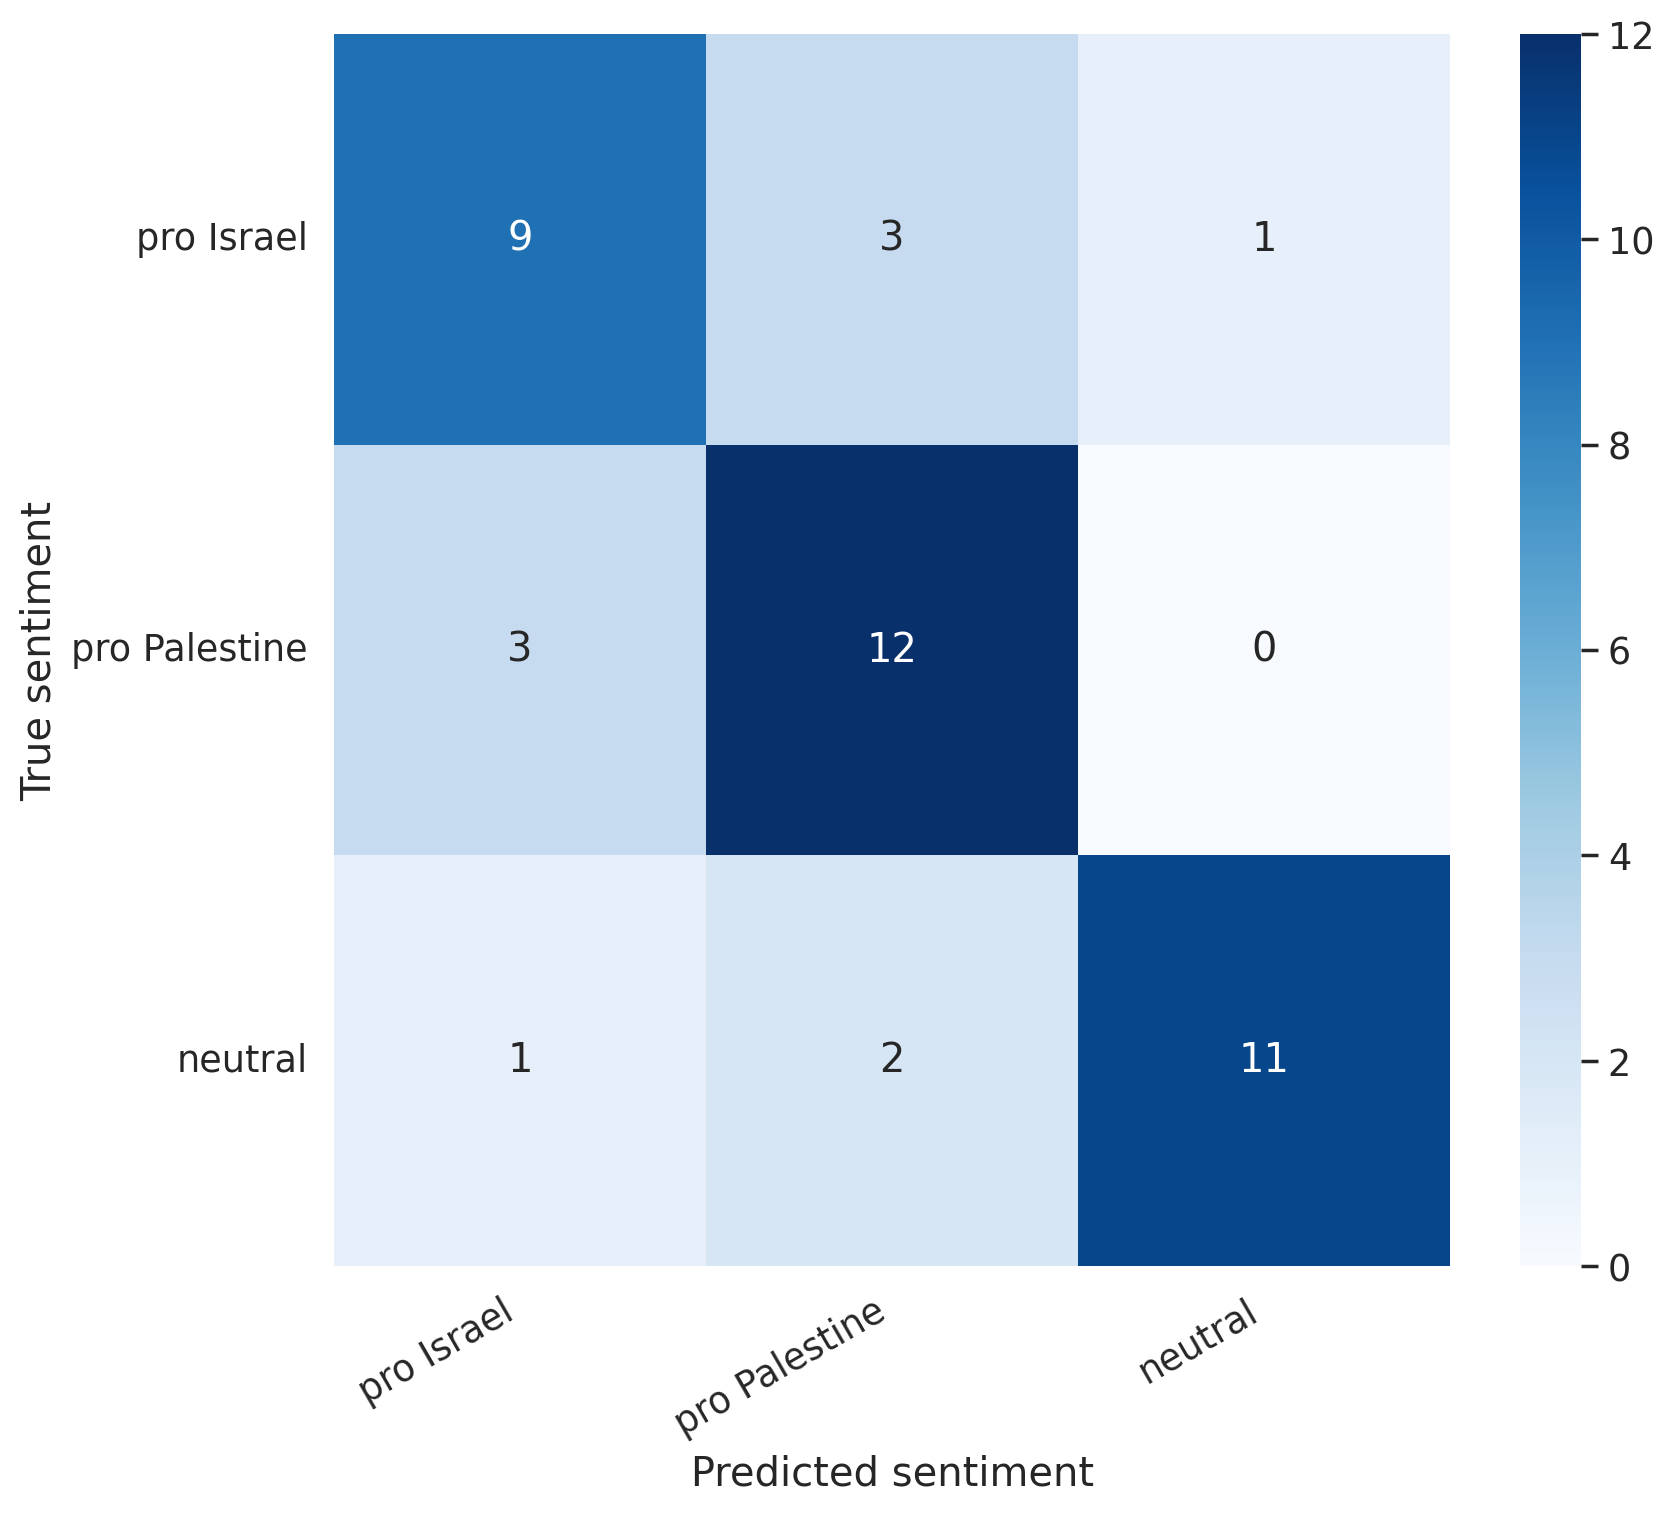

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 19

comment_text = y_comment_text[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
!pip install textwrap
from textwrap import wrap

ERROR: Could not find a version that satisfies the requirement textwrap (from versions: none)
ERROR: No matching distribution found for textwrap


In [ ]:
print("\n".join(wrap(comment_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

under international law , resistance is justified when people are
occupied and palestinian have that right

True sentiment: pro Palestine


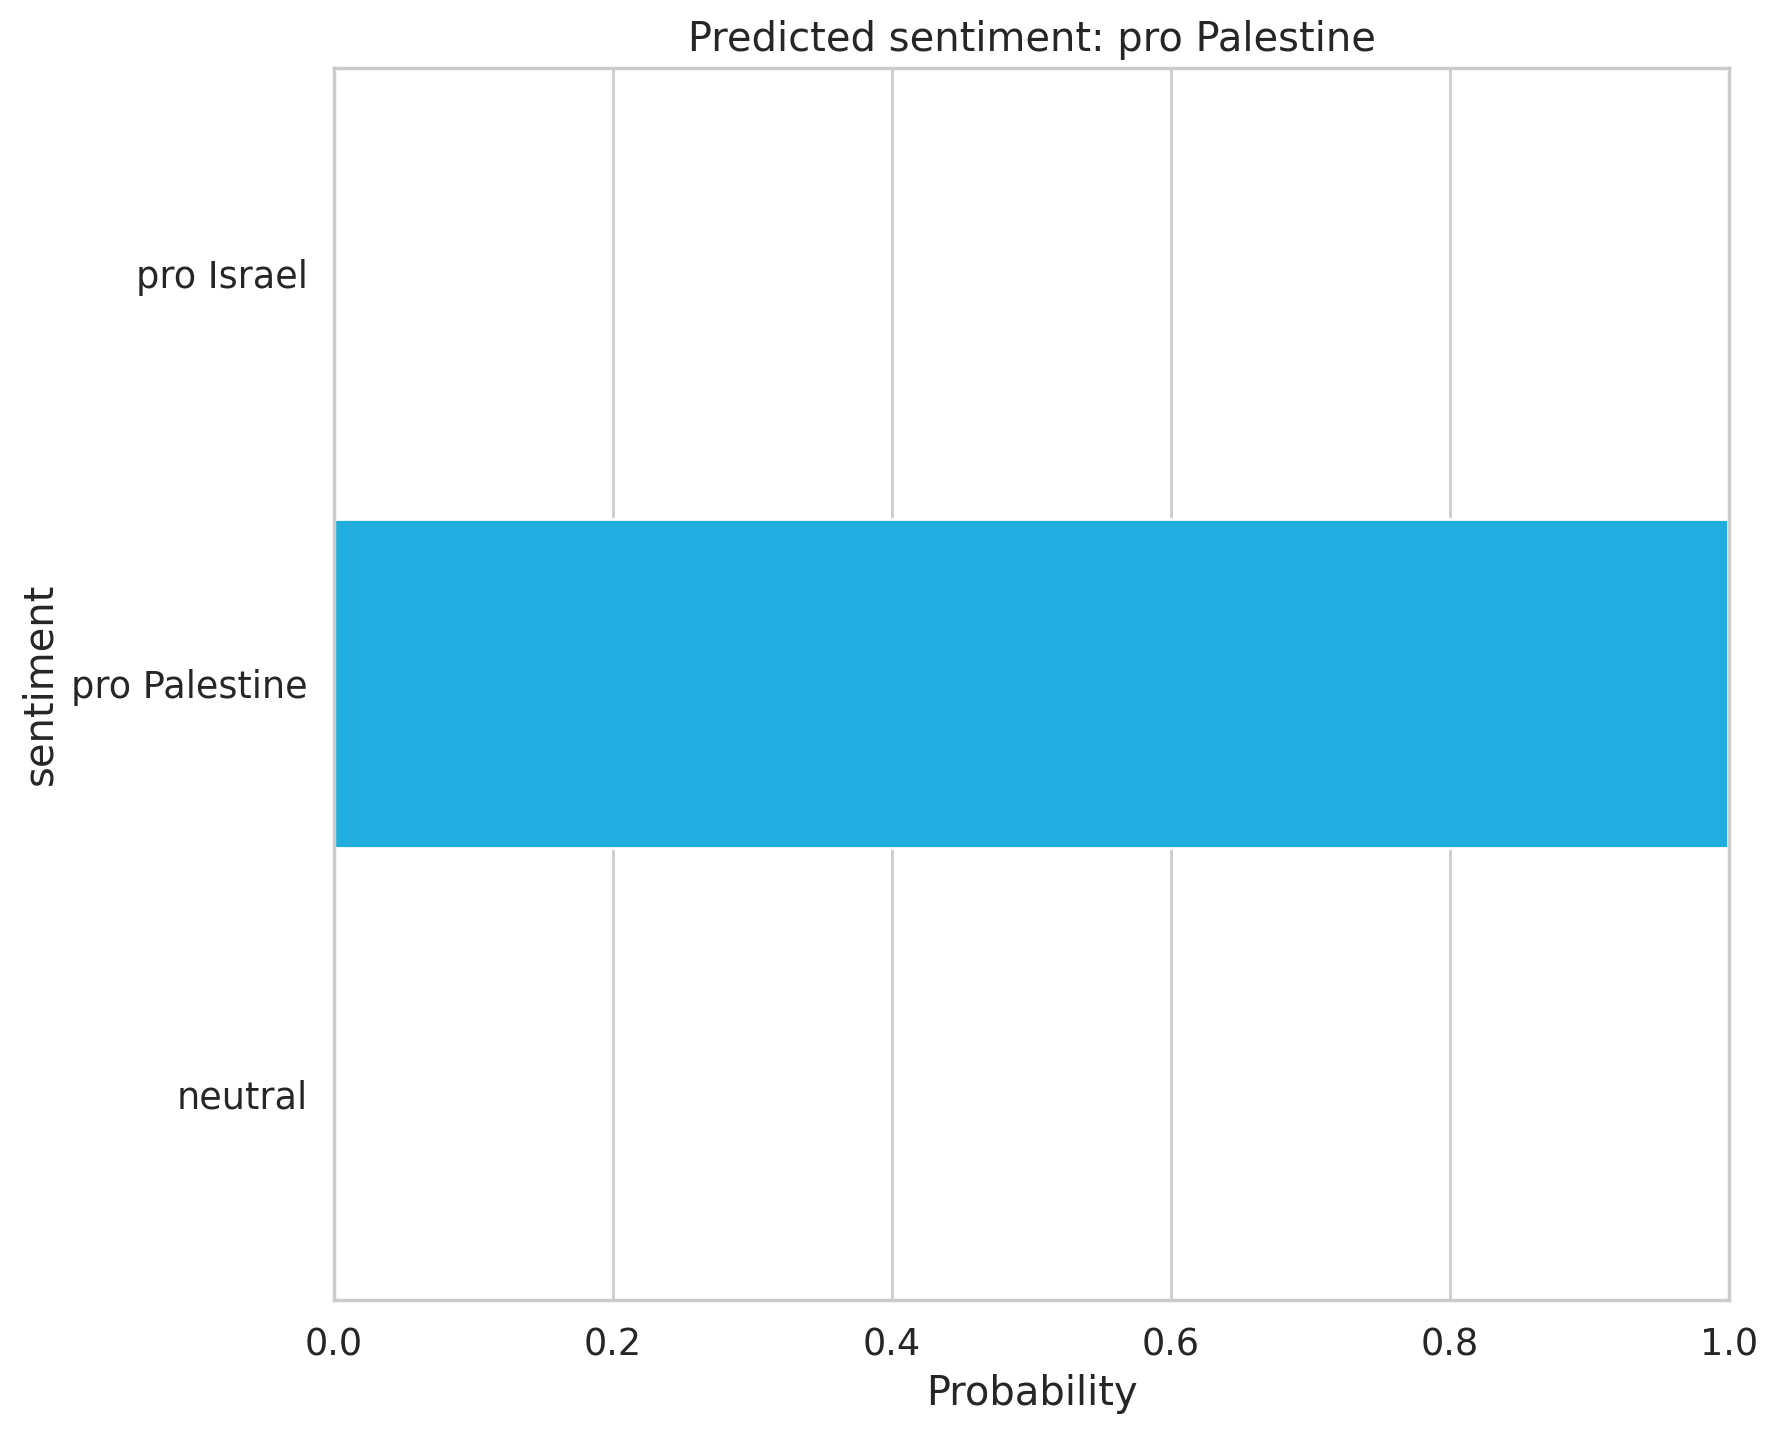

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('Probability')
plt.xlim([0, 1])
plt.title(f'Predicted sentiment: {class_names[y_pred[idx]]}');

predict sentiment on raw text

In [ ]:
review_text_1 = 'the war is never right, they should agree for peace and sto this war'
#'Israel is committing a genocide'
#'Palestine has the right to fight and destroy its invasors'
#'the war is never right, they should agree for peace and sto this war'

encode_review_1 = tokenizer.encode_plus(
    review_text_1,
    max_lenght = MAX_LEN,
    add_special_tokens = True,
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt',
)

Keyword arguments {'max_lenght': 200} not recognized.


In [ ]:
encode_review_1

{'input_ids': tensor([[ 101, 1996, 2162, 2003, 2196, 2157, 1010, 2027, 2323, 5993, 2005, 3521,
         1998, 2358, 2080, 2023, 2162,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
input_ids = encode_review_1['input_ids'].to(device)
attention_mask = encode_review_1['attention_mask'].to(device)

In [ ]:
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim= 1)

In [ ]:
print(f'comment: {review_text_1}')
print(f'Sentiment: {class_names[prediction]}')

comment: the war is never right, they should agree for peace and sto this war
Sentiment: neutral


Save the trained model

# SENTIMENT ANALYSIS PROGETTO
